<figure>
  <IMG SRC="https://raw.githubusercontent.com/mbakker7/exploratory_computing_with_python/master/tudelft_logo.png" WIDTH=250 ALIGN="right">
</figure>

# An Introduction to the Finite Diffence Method I
*Mark Bakker*

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import *

## Introduction

The finite difference method is a grid-based method. The model area is divided in a grid of rectangular cells. The head is computed at the center of the rectangles and the flow is computed between cells. Cells are numbered row-wise. For example, a grid with 3 rows and 4 columns is numbered as

$$
\begin{array}{|c|c|c|c|}
\hline 
    0&1&2&3 \\ \hline 
    4&5&6&7 \\ \hline 
    8&9&10&11 \\ \hline 
\end{array}$$

The reason for this numbering system is that Python stores two-dimensional arrays in this order.

In [2]:
a = np.arange(12)
a.shape = (3,4)
print(a)

[[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]]


For a system with $n_c$ columns, the neighbors of cell $i$ (counter-clockwise starting from the right side) are $i+1$, $i-n_c$, $i-1$, and $i+n_c$, as shown below.


$$
\begin{array}{|c|c|c|}
\hline 
    & i-n_c &  \\ \hline
    i-1 & i & i+1 \\\hline
       & i+n_c &  \\\hline
\end{array}$$


Finite difference equations are derived by considering a volume balance for one cell. The cell discharge is defined as the total discharge [L$^3$/T] from one cell to another cell. The cell discharge through the right side of cell $i$ is called $U_i$ and the cell discharge through the front side of cell $i$ is called $V_i$ (see Figure). 

![](fd_fig1.png)

Using this convention, the cell discharge through the left side is $U_{i-1}$ and through the back side is $V_{i-n_c}$. Cell discharges through the right side are positive for flow to the right, and cell discharges through the front side are positive for flow to the front. For steady-state conditions, continuity of flow states that

$$\text{In} = \text{Out}$$

or

$$U_{i-1}+V_{i-n_c} + Q_i = U_i + V_i$$

where $Q_i$ is the source term of cell $i$, the discharge [L$^3$/T] that flows into cell $i$ from outside sources like wells or areal infiltration. The continuity equation is more commonly written as

$$U_i + V_i - U_{i-1} - V_{i-n_c} = Q_i$$

## Flow between two cells

Before considering the flow between two cells, consider one-dimensional flow between two canals with head $h_1$ in the left canal and $h_2$ in the right canal. The hydraulic conductivity between the two canals consists of two zones. The left zone has length $L_1/2$, hydraulic conductivity $k_1$, and thickness $H_1$ so that $T_1=k_1H_1$. The right zone has length $L_2/2$, hydraulic conductivity $k_2$, and thickness $H_2$ so that $T_2=k_2H_2$. The total width of the canal, normal to the plane of flow, is $W$. The total discharge [L$^3$/T] from the left canal to the right canal may be written as

$$Q = W \frac{2T_1 T_2}{T_2 L_1 + T_1 L_2} (h_1 - h_2)$$

This means that the discharge between the two canals can be written as a factor times the head difference between the two canals. 

The total discharge $U_i$ from cell $i$ to cell $i+1$ can be written in the form

$$U_i = C_i(h_i-h_{i+1})$$

where $C_i$ is called the conductance from cell $i$ to cell $i+1$ through the right side of cell $i$, which can be written as

$$C_i = W_i \frac{2T_{i} T_{i+1}}{T_{i+1} L_i + T_i L_{i+1}} $$

Similarly, the total discharge $V_i$ from cell $i$ to cell $i+n_c$ can be written as

$$V_i = D_i(h_i-h_{i+n_c})$$

where $D_i$ is the conductance from cell $i$ to cell $i+n_c$ through the front side of cell $i$

$$D_i = L_i \frac{2T_{i} T_{i+n_c}}{T_{i+n_c} W_i + T_i W_{i+n_c}} $$

## Governing equation

Substitution of the equation for the flow through the right face and the front face into the water balance gives

$$C_i(h_i - h_{i+1}) + D_i(h_i - h_{i+n_c}) - C_{i-1}(h_{i-1}-h_i) - D_{i-n_c}(h_{i-n_c}-h_i) = Q_i$$

or, after some rearrangement

$$C_i h_{i+1} + D_i h_{i+n_c} + C_{i-1} h_{i-1} + D_{i-n_c} h_{i-n_c} - 
(C_i + D_i + C_{i-1} + D_{i-n_c}) h_i = -Q_i$$

Notice that the term in front of $h_i$ is negative the sum of the conductances of the four other terms in the equation. The above equation is valid for each cell, but we have to define a special rule if a cell has one or more sides that form the boundary of a model. Let’s agree that if a cell has a side that is along the boundary, than the conductance of the side along the boundary is zero. As such, all the boundaries of the model are impermeable. (We will modify this later on, but this is our basic model.) For example, consider cell 7 in the system of 4 by 4 cells that was shown earlier. The conductance of its right side is zero: $C_7=0$, so that the water balance equation reduces to

$$D_7 h_{11} + C_{6} h_{6} + D_{3} h_{3} - 
(D_7 + C_{6} + D_{3}) h_7 = -Q_7$$

Note again, that the term in front of $h_7$ is minus the sum of the conductances in front of the other terms. Interestingly enough, this holds for all boundary cells, and thus for any cell in the model. We will make use of this feature later on.

## Building the system of equations

We have a water balance equation for every cell. The total number of unknown heads is equal to the number of rows times the number of columns ($N=n_rn_c$). So we can build one big system of $N$ equations, which we
￼can write as

$$\mathbf{A}\vec{h} = \vec{Q}$$

Inspection of the water balance equation for a cell should lead you to conclude that the matrix $\mathbf{A}$ contains mostly zeros. To be precise, every row will have at most five non-zero terms. Matrices with such few non-zero terms are referred to as sparse matrices. There are all kinds of efficient algorithms available for solving sparse matrices, but we will start with building a regular matrix.

Let’s first do a little example of 3 rows by 4 columns. The numbering of the cells is than as follows

$$
\begin{array}{|c|c|c|c|}
\hline 
    0&1&2&3 \\ \hline 
    4&5&6&7 \\ \hline 
    8&9&10&11 \\ \hline 
\end{array}$$

The matrix has 12 equations, numbered 0 through 11. We will apply the water balance equation to compute all non-zero terms in the matrix, except for the values on the diagonal. The value on the diagonal is, as we have shown earlier, minus the sum of all the other values in the row, indicated with $-\Sigma$ in the matrix below. The non-zero terms in the matrix look as follows:

$$
\left(
\begin{array}{c c c c c c c c c c c c}
-\Sigma& C_0  & \cdot& \cdot& D_0  & \cdot& \cdot& \cdot& \cdot& \cdot& \cdot& \cdot  \\
C_0  & -\Sigma& C_1  & \cdot& \cdot& D_1  & \cdot& \cdot& \cdot& \cdot& \cdot& \cdot  \\
\cdot& C_1  & -\Sigma& C_2  & \cdot& \cdot& D_2  & \cdot& \cdot& \cdot& \cdot& \cdot  \\
\cdot& \cdot& C_2  & -\Sigma& C_3  & \cdot& \cdot& D_3  & \cdot& \cdot& \cdot& \cdot  \\
D_0  & \cdot& \cdot& C_3  & -\Sigma& C_4  & \cdot& \cdot& D_4  & \cdot& \cdot& \cdot  \\
\cdot& D_1  & \cdot& \cdot& C_4  & -\Sigma& C_5  & \cdot& \cdot& D_5  & \cdot& \cdot  \\
\cdot& \cdot& D_2  & \cdot& \cdot& C_5  & -\Sigma& C_6  & \cdot& \cdot& D_{6} & \cdot  \\
\cdot& \cdot& \cdot& D_3  & \cdot& \cdot& C_6  & -\Sigma& C_7  & \cdot& \cdot& D_{7}      \\
\cdot& \cdot& \cdot& \cdot& D_4  & \cdot& \cdot& C_7  & -\Sigma& C_8  & \cdot& \cdot  \\
\cdot& \cdot& \cdot& \cdot& \cdot& D_5  & \cdot& \cdot& C_8  & -\Sigma& C_9  & \cdot  \\
\cdot& \cdot& \cdot& \cdot& \cdot& \cdot& D_{6}  & \cdot& \cdot& C_9  & -\Sigma& C_{10}   \\
\cdot& \cdot& \cdot& \cdot& \cdot& \cdot& \cdot& D_{7}  & \cdot& \cdot& C_{10}    & -\Sigma  \\
\end{array}\right)
\left(
\begin{array}{c}
h_0 \\ h_1 \\ h_2 \\ h_3 \\ h_4 \\ h_5 \\ h_6 \\ h_7 \\ h_8 \\ h_9 \\ h_{10} \\ h_{11} 
\end{array}\right) = -
\left(
\begin{array}{c}
Q_0 \\ Q_1 \\ Q_2 \\ Q_3 \\ Q_4 \\ Q_5 \\ Q_6 \\ Q_7 \\ Q_8 \\ Q_9 \\ Q_{10} \\ Q_{11} 
\end{array}\right)
$$

Note that $C_3$ and $C_7$ are included in the matrix for consistency, but are actually zero. 

Looking at this matrix, we conclude that non-zero values only occur along 5 diagonals. The main diagonal is numbered 0, diagonals above it are positive, below it negative. As such, we have values along diagonals $−n_c$,−1, 0, 1, and $n_c$. Diagonals $-1$ and $+1$ contain the values of the right-side conductance $C_i$ from $i=0$ through (but not including) $N-1$, where $C_i$ is computed with the equation given above, except for cells $i=n_c-1,2n_c-1,...$, which are zero. Diagonals $n_c$ and $-n_c$ contain the front-face conductances $D_i$ for $i=0$ up to and including $i=N-n_c-1$. The main diagonal (numbered 0) contains minus the sum of all the other values in the row.

## Cells with specified head

When a cell has a specified head, the equation for that cell is replaced by a 1 on the main diagonal, zeros elsewhere in the row, and the specified value of the head in the right-hand side.

## First finite difference program

We are going to build a first finite difference program. We make a model with `nc` columns and `nr` rows. The input consists of the following variables

In [3]:
nc = 4 # number of columns
nr = 3 # number of rows
L = 10 * np.ones(nc) # length of cells along row
W = 5 * np.ones(nr)  # length of cells along column
k = 10 * np.ones((nr,nc)) # k values of cells
H = 20 * np.ones((nr,nc)) # thickness of cells
Q = np.zeros((nr,nc))  # source terms of cells
Q[0, 1] = 10
Q[2, 2] = -10
Fh = np.full((nr,nc), np.nan) # fixed head cells
Fh[0, 0] = 7
Fh[2, 3] = 8

One-dimensional arrays are created of the length of all the cells, the width of all the cells, and the transmissivity of all the cells. An array is created with the cell numbers and an array with the cell numbers of the cells with fixed heads.

In [4]:
Lf = np.tile(L, (nr,1)).flat
Wf = np.tile(W[:, np.newaxis], (1, nc)).flat
kH = (k * H).flat
cellnumbers = np.arange(nr * nc)
fixed = cellnumbers[~np.isnan(Fh.flat)]

The conductance $C$ and $D$ is computed for all cells

In [5]:
C = Wf[:-1] * 2 * kH[:-1] * kH[1:] / (
    kH[1:] * Lf[:-1] + kH[:-1] * Lf[1:] )
C[nc-1::nc] = 0
D = Lf[:-nc] * 2 * kH[nc:] * kH[:-nc] / (
    kH[nc:] * Wf[:-nc] + kH[:-nc] * Wf[nc:] )

The matrix and right-hand-side are constructed

In [6]:
A = np.diag(C, 1) + np.diag(C, -1) + np.diag(D, nc) + np.diag(D, -nc) 
A -= np.diag(A.sum(1))
rhs = -Q.flat[:]

The matrix and right-hand side are adjusted for fixed-head cells

In [7]:
A[fixed, :] = 0
A[fixed, fixed] = 1
rhs[fixed] = Fh.flat[fixed]

The heads are solved and the head array is converted to the right shape

In [8]:
h = np.linalg.solve(A, rhs)
h.shape = (nr, nc)

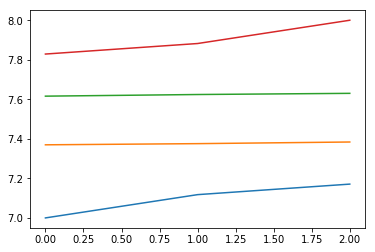

In [9]:
plt.figure()
plt.plot(h)
plt.show()

## Create finite difference function

The entire finite difference solution may now be gathered into the following function.

In [10]:
def fdflow_full(nc, nr, L, W, k, H, Q, Fh):
    # Flat matrices
    Lf = np.tile(L, (nr, 1)).flat
    Wf = np.tile(W[:, np.newaxis], (1, nc)).flat
    kH = (k * H).flat
    cellnumbers = np.arange(nr * nc)
    fixed = cellnumbers[~np.isnan(Fh.flat)]
    # Conductances
    C = Wf[:-1] * 2 * kH[:-1] * kH[1:] / (
        kH[1:] * Lf[:-1] + kH[:-1] * Lf[1:])
    C[nc-1::nc] = 0
    D = Lf[:-nc] * 2 * kH[nc:] * kH[:-nc] / (
        kH[nc:] * Wf[:-nc] + kH[:-nc] * Wf[nc:] )
    # Matrix and rhs
    A = np.diag(C, 1) + np.diag(C, -1) + np.diag(D, nc) + np.diag(D, -nc) 
    A -= np.diag(A.sum(1).flat)
    rhs = -Q.flat[:]  #shape discharge into vector
    # Fixed heads
    A[fixed, :] = 0
    A[fixed, fixed] = 1
    rhs[fixed] = Fh.flat[fixed]
    # Solve and set shape
    h = np.linalg.solve(A, rhs)
    h.shape = (nr, nc)
    return h

The same solution is still obtained when calling the function

In [11]:
nc = 4
nr = 3
L = 10 * np.ones(nc)
W = 5 * np.ones(nr)
k = 10 * np.ones((nr, nc))
H = 20 * np.ones((nr, nc))
Q = np.zeros((nr, nc))
Q[0, 1] = 10
Q[2, 2] = -10
Fh = np.full((nr, nc), np.nan)
Fh[0, 0] = 7
Fh[2, 3] = 8
h = fdflow_full(nc, nr, L, W, k, H, Q, Fh)
print(h)

[[ 7.          7.36982249  7.61597633  7.82899408]
 [ 7.11775148  7.37573964  7.62426036  7.88224852]
 [ 7.17100592  7.38402367  7.63017751  8.        ]]


## Sparse matrices

The matrix $\mathbf{A}$ that we built to compute the finite difference solution is a sparse matrix with non-zero elements along five diagonals only. Storing such a sparse matrix as a full matrix means storing a lot of zeros. For larger models, with lots of cells, you will quickly run out of computer memory. It is much more efficient to only store the non-zero values of the matrix, together with their location (row and column number) in the matrix. `scipy` includes an extensive sparse matrix packages, which contains several different formats of sparse matrices. Each format is most efficient for a specific structure of the matrix and for specific manipulations that you want to do. We will use the 'compressed sparse row matrix' or `csr` format, which allows the for fast manipulation of rows. A sparse matrix can be created from diagonals using the `diags` function, where you need to provide a list of diagonals and a list of the offsets of the diagonals (like above). For example, consider a matrix with values on the main diagonal and on the first off-diagonal above the main diagonal.

In [12]:
from scipy.sparse import diags
A = diags([np.arange(1, 6), 7 * np.ones(4)], [0, 1], format = 'csr')

Matrix `A` is now a sparse matrix, and only the locations and values of the sparse matrix are stored

In [13]:
print(A)

  (0, 0)	1.0
  (0, 1)	7.0
  (1, 1)	2.0
  (1, 2)	7.0
  (2, 2)	3.0
  (2, 3)	7.0
  (3, 3)	4.0
  (3, 4)	7.0
  (4, 4)	5.0


Matrix `A` can be converted to a regular `numpy` array with the `toarray` function. You probably wouldn't do this very often, as it kind of defeats the purpose, but it is illustrative here to check that we do indeed get the matrix that we wanted. 

In [14]:
A.toarray()

array([[ 1.,  7.,  0.,  0.,  0.],
       [ 0.,  2.,  7.,  0.,  0.],
       [ 0.,  0.,  3.,  7.,  0.],
       [ 0.,  0.,  0.,  4.,  7.],
       [ 0.,  0.,  0.,  0.,  5.]])

The function `fdflow` is the equivalent of the `fdflow_full` function, but uses sparse matrices rather than full matrices. The only difference is the use of the `diags` function to create a matrix from diagonals, and the `spsolve` function to obtain the solution for a sparse matrix. 

In [2]:
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve

def fdflow(nc, nr, L, W, k, H, Q, Fh):
    # Flat matrices
    Lf = np.tile(L, nr)
    Wf = np.repeat(W, nc)
    kH = (k * H).flat
    cellnumbers = np.arange(nr * nc)
    fixed = cellnumbers[~np.isnan(Fh.flat)]
    # Conductances
    C = Wf[:-1] * 2 * kH[:-1] * kH[1:] / (
        kH[1:] * Lf[:-1] + kH[:-1] * Lf[1:] )
    C[nc-1::nc] = 0
    D = Lf[:-nc] * 2 * kH[nc:] * kH[:-nc] / (
        kH[nc:] * Wf[:-nc] + kH[:-nc] * Wf[nc:] )
    # Matrix and rhs
    if len(D) == 0:
        A = diags([C, C], [1, -1], format='csr')  # model with 1 row
    else:
        A = diags([C, C, D, D], [1, -1, nc, -nc], format='csr')
    A -= diags(A.sum(1).flat, 0)
    rhs = -Q.flat[:]
    # Fixed heads
    A[fixed,:] = 0
    A[fixed, fixed] = 1
    rhs[fixed] = Fh.flat[fixed]
    h = spsolve(A, rhs)
    h.shape = (nr, nc)
    return h

The same solution is obtained as with the full matrix.

In [16]:
nc = 4
nr = 3
L = 10 * np.ones(nc)
W = 5 * np.ones(nr)
k = 10 * np.ones((nr, nc))
H = 20 * np.ones((nr, nc))
Q = np.zeros((nr, nc))
Q[0,1] = 10
Q[2,2] = -10
Fh = np.full((nr, nc), np.nan)
Fh[0, 0] = 7
Fh[2, 3] = 8
h = fdflow(nc, nr, L, W, k, H, Q, Fh)
print(h)

[[ 7.          7.36982249  7.61597633  7.82899408]
 [ 7.11775148  7.37573964  7.62426036  7.88224852]
 [ 7.17100592  7.38402367  7.63017751  8.        ]]


F:\Anaconda\lib\site-packages\scipy\sparse\compressed.py:774: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


You likely got a warning to pop-up that the use of a `csr` matrix is not efficient when constructing the matrix $\mathbf{A}$, but it was tested and for this case the `csr` matrix is faster than the `lil` matrix, and a `csr` matrix is required for obtaining a solution with `spsolve`. Let's turn this warning off for the remainder of this Notebook, as it can get pretty annoying.

In [17]:
from scipy.sparse import SparseEfficiencyWarning
import warnings
warnings.simplefilter(action='ignore', category=SparseEfficiencyWarning)

In [18]:
h = fdflow(nc, nr, L, W, k, H, Q, Fh)
print(h)

[[ 7.          7.36982249  7.61597633  7.82899408]
 [ 7.11775148  7.37573964  7.62426036  7.88224852]
 [ 7.17100592  7.38402367  7.63017751  8.        ]]


## Performance of full matrix vs. sparse matrix

The performance of the finite difference method is tested for a simple model with only 31 by 41 cells (1271 cells total) and two head-specified cells. For this small model, the solution with a sparse matrix is already 16 times faster than the solution with a full matrix. Performance difference increases rapidly with number of cells. When doubling the number of cells in both directions (so 4 times as many cells), the solution with the sparse matrix is approximately 160 times faster than the solution with the full matrix (try it!).

In [19]:
nc = 41
nr = 31
L = 10 * np.ones(nc)
W = 5 * np.ones(nr)
k = 10 * np.ones((nr, nc))
H = 20 * np.ones((nr, nc))
Q = np.zeros((nr, nc))
Fh = np.full((nr, nc), np.nan)
Fh[0, 0] = 70
Fh[-1, -1] = 90

In [20]:
timeit h = fdflow(nc, nr, L, W, k, H, Q, Fh)

4.77 ms ± 76.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [21]:
timeit h = fdflow_full(nc, nr, L, W, k, H, Q, Fh)

70.2 ms ± 1.59 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Contour plot

A contour plot may be created with the `contour` function of `matplotlib`. The $x$ and $y$ coordinates of the centers of the cells need to be computed from the `L` and `W` arrays that contain the lengths and widths of the cells. This is always a bit cumbersome, so let's write a function to do that. First, the distances between the cell centers are computed, then the $x$ and $y$ coordinates of the cell centers are computed. As the first row of a matrix is at the top of the matrix, the computed $y$ values are put in reverse order, so that the origin is at the lower left-hand corner.

In [6]:
def xy(L, W):
    # Center of lower left-hand cell is (0,0)
    dx = 0.5 * (L[:-1] + L[1:])
    x = np.hstack((0, np.cumsum(dx)))
    dy = 0.5 * (W[:-1] + W[1:])
    y = np.hstack((0, np.cumsum(dy)))
    y = y[::-1]
    return x, y
xy(L, W)

(array([    0.,    20.,    40.,    60.,    80.,   100.,   120.,   140.,
          160.,   180.,   200.,   220.,   240.,   260.,   280.,   300.,
          320.,   340.,   360.,   380.,   400.,   420.,   440.,   460.,
          480.,   500.,   520.,   540.,   560.,   580.,   600.,   620.,
          640.,   660.,   680.,   700.,   720.,   740.,   760.,   780.,
          800.,   820.,   840.,   860.,   880.,   900.,   920.,   940.,
          960.,   980.,  1000.,  1020.,  1040.,  1060.,  1080.,  1100.,
         1120.,  1140.,  1160.,  1180.,  1200.,  1220.,  1240.,  1260.,
         1280.,  1300.,  1320.,  1340.,  1360.,  1380.,  1400.,  1420.,
         1440.,  1460.,  1480.,  1500.,  1520.,  1540.,  1560.,  1580.,
         1600.,  1620.,  1640.,  1660.,  1680.,  1700.,  1720.,  1740.,
         1760.,  1780.,  1800.,  1820.,  1840.,  1860.,  1880.,  1900.,
         1920.,  1940.,  1960.,  1980.,  2000.,  2020.,  2040.,  2060.,
         2080.,  2100.,  2120.,  2140.,  2160.,  2180.,  2200., 

(0.0, 400.0, 0.0, 150.0)

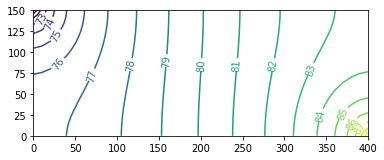

In [23]:
h = fdflow(nc, nr, L, W, k, H, Q, Fh)
x, y = xy(L, W)
cs = plt.contour(x, y, h, 20)
plt.clabel(cs, fmt='%1.0f')
plt.axis('scaled')


In [24]:
#if u don't specify boundary condition, the programme set default as impermeable boundary

## Exercise 1. Flow between two canals

Consider steady one-dimensional flow between two long, parallel canals. The canals are 1000 m apart. The canal on the left has a head $h=10$ m above the base of the aquifer and the canal on the right has a head $h=20$ m above the base of the aquifer. The hydraulic conductivity of the aquifer is 1 m/d. The recharge rate of the aquifer is 0.002 m/d. 

Questions:

a) Develop a finite difference solution using that the saturated thickness of the aquifer may be approximated as constant and equal to $H=15$ m. Compare your finite difference solution to the exact solution for an aquifer with $H=15$ m by creating a graph that shows both. 

b) Develop a finite difference solution for the case that the flow is unconfined and the saturated thickness of the aquifer varies with the head. You may need to iterate by adjusting the aquifer thickness several times. Compare your finite difference solution to the exact solution for unconfined flow by by creating a graph that shows both. 

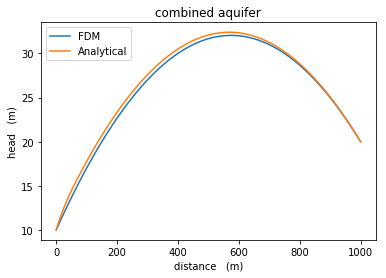

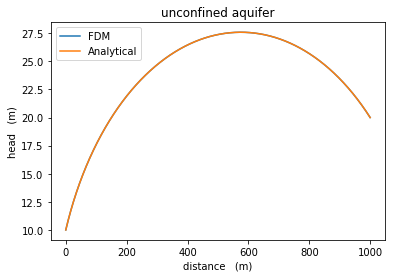

[[  0.00000000e+00   1.86940525e-08   2.98126626e-08 ...,  -2.10828865e-08
   -1.08908260e-08   0.00000000e+00]] Thickness and head has been converged already


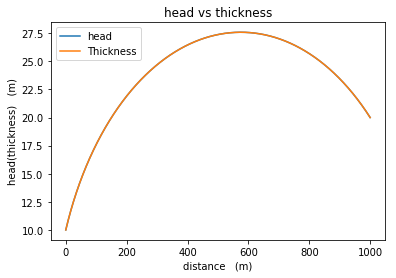

In [25]:
# unconfined aquifer , convergence between thickness and head
#Analytical solution
N = 0.002
X = np.linspace(0,1000,10001)
phi_left = 1/2*1*10**2
phi_right = 1*20*15-1/2*1*15**2
B = phi_left
A = (phi_right-phi_left)/1000 + N/2*1000
phi = -N/2*X**2+A*X+B
phic =   1/2*1 * 15 ** 2
h_combined = zeros_like(phi)
h_combined[phi >= phic] = (phi[phi >= phic] + 0.5 * 1 * 15 ** 2) / (1 * 15)
h_combined[phi < phic] = sqrt(2 * phi[phi < phic] / 1)

#a) confined aquifer
     #FDM
nc = 10001
nr = 1
L = np.ones(nc) * 0.1
W = 1
k = np.ones((nr,nc)) * 1
H = np.ones((nr,nc)) * 15
Q = 0.002 * L * W
Fh = np.full((nr,nc),np.nan)
Fh[0,0] = 10
Fh[-1,-1] = 20
h_confined = fdflow(nc, nr, L, W, k, H, Q, Fh)
plt.figure()
plt.plot(X,h_confined[0,:],label = 'FDM')
plt.plot(X,h_combined, label= 'Analytical')
plt.legend()
plt.title("combined aquifer")
plt.xlabel("distance   (m)")
plt.ylabel("head   (m)")
plt.show()

#unconfined aquifer
    #Analytical
phi_left = 1/2*1*10**2
phi_right = 1/2*1*20**2
B = phi_left
A = (phi_right-phi_left)/1000 + N/2*1000

phi = -N/2*X**2+A*X+B
h_unconfined_1 = np.sqrt(2*phi/1)
    #FDM

def dynamic(nc, nr, L, W, k, H, Q, Fh):
    h = fdflow(nc, nr, L, W, k, H, Q, Fh)
    if max(abs(h[0,1:len(x)]-H[0,1:len(x)]))<1e-4:
        return h,H
    H = h
    return dynamic(nc, nr, L, W, k, H, Q, Fh)
h_unconfined, H = dynamic(nc, nr, L, W, k, H, Q, Fh)
plt.figure()
plt.plot(X,h_unconfined[0,:],label = 'FDM')
plt.plot(X,h_unconfined_1, label= 'Analytical')
plt.title("unconfined aquifer")
plt.legend()
plt.xlabel("distance   (m)")
plt.ylabel("head   (m)")
plt.show()

print(h_unconfined - H ,"Thickness and head has been converged already")
plt.figure()
plt.plot(X,h_unconfined[0,:],label = 'head')
plt.plot(X,H[0],label = 'Thickness')
plt.title("head vs thickness")
plt.legend()
plt.xlabel("distance   (m)")
plt.ylabel("head(thickness)   (m)")
plt.show()

## Exercise 2. Flow to a well

Consider a confined aquifer with a hydraulic conductivity $k=10$ m/d and thickness $H=20$ m. Develop a square model of 2000 by 2000 meter. A well is located at the center of the model. The discharge of the well is 1000 m$^3$/d and the radius of the well is 0.2 m. The head along the model boundary is fixed to $40$ m. Compute a finite difference solution using 51 by 51 square cells. Make a contour plot of the head. In a separate figure, plot the head along a straight line through the center of the model together with the exact solution for a well in a circular island with radius 1000 m.

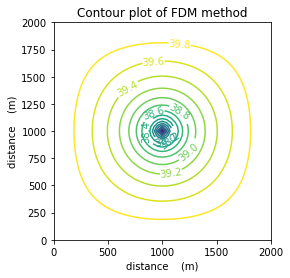

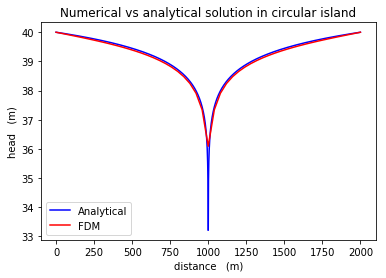

In [26]:
#np.hstack() #stack two arrays horizontally
#np.vstack() # stack vertically
# FDM
nc = 51
nr = 51
L = np.ones(nc) * 2000/50
W = np.ones(nr) * 2000/50
k = np.ones((nr,nc)) * 10
H = np.ones((nr,nc)) * 20
Q = np.zeros((nr,nc))
Q[25,25] = -1000
Fh = np.full((nr,nc),np.nan)
Fh[0:51,0] = 40
Fh[0:51,50] = 40
Fh[0,0:51] = 40
Fh[50,0:51] = 40
h_FDM = fdflow(nc, nr, L, W, k, H, Q, Fh)
plt.figure()
x, y = xy(L, W)
cs = plt.contour(x, y, h_FDM, 20)
plt.clabel(cs, fmt='%1.1f')
plt.axis('scaled')
plt.title("Contour plot of FDM method")
plt.xlabel("distance    (m)")
plt.ylabel("distance    (m)")
plt.show()
# Analytical
phi_R = 10*20*40
rw = 0.2
R = np.linspace(rw, 1000,2000)
phi_analytical = phi_R + 1000/2/np.pi*np.log(R/1000)
h_analytical = phi_analytical/10/20

plt.figure()
plt.plot(R+1000,h_analytical,c='b',label = 'Analytical')
plt.plot(-R+1000,h_analytical, c='b')
plt.plot(xy(L,W)[0],h_FDM[25,:],c = 'r', label='FDM')
plt.title("Numerical vs analytical solution in circular island")
plt.xlabel("distance   (m)")
plt.ylabel("head   (m)")
plt.legend()
plt.show()

## Exercise 3. Improve the drawdown at the well
Try to improve the drawdown of your model at the well by dividing the cell that contains the well in 11 by 11 smaller cells. Hint: arrays may be put back-to-back using the `np.hstack` command.

In [27]:
nc_confined = 11
nr_confined = 11
L_refined = np.ones(nc_confined) * 2000/50/(nc_confined-1)
W_refined = np.ones(nr_confined) * 2000/50/(nr_confined-1)
L = np.hstack((L[0:25],L_refined,L[26:]))
W = np.hstack((W[:25],W_refined,W[26:]))
nr = len(L)
nc = len(W)
k = np.ones((nr,nc)) * 10
H = np.ones((nr,nc)) * 20
Q = np.zeros((nr,nc))
Q[int((nr-1)/2),int((nc-1)/2)] = -1000
Fh = np.full((nr,nc),np.nan)
Fh[0:nr,0] = 40
Fh[0:nr,nc-1] = 40
Fh[0,0:nc] = 40
Fh[nr-1,0:nc] = 40
h_FDM_center = fdflow(nc, nr, L, W, k, H, Q, Fh)

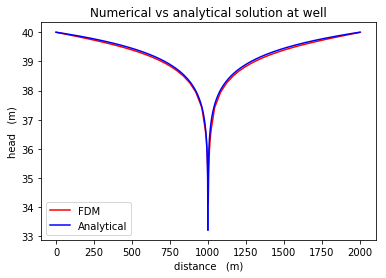

In [28]:
plt.figure()
plt.plot(xy(L,W)[0], h_FDM_center[int((nr-1)/2),:],c='r', label="FDM")
plt.plot(R+1000,h_analytical,c='b',label = 'Analytical')
plt.plot(-R+1000,h_analytical, c='b')
plt.title("Numerical vs analytical solution at well")
plt.xlabel("distance   (m)")
plt.ylabel("head   (m)")
plt.legend()
plt.show()

## Exerise 4. Flow to a well near a river

Create a model for a well near a straight river that runs from North to South along the Eastern boundary of the model. The model is 3000 m long and 2000 m wide and the origin is at the lower-left hand corner. The river is located along $x=3000$. A well is located at $(x,y)=(2000,1000)$ and has discharge $Q=400$ m$^3$/d.  The groundwater flow is uniform towards the river in absence of the well with a gradient of $\partial h/\partial x = -0.002$. The aquifer is confined with $k=10$ m/d, and $H=20$ m.   The head in the river is 40 m. Use a rectangular grid. Create a contour plot of the head. What is the drawdown at the well (there is no need to refine at the well). 

In [61]:
h_FDM

array([[ 45.02573649,  44.98574152,  44.9457516 , ...,  40.04446008,
         40.0222272 ,  40.        ],
       [ 45.02570503,  44.98570995,  44.9457198 , ...,  40.0443891 ,
         40.02219174,  40.        ],
       [ 45.02564286,  44.98564754,  44.94565693, ...,  40.04424794,
         40.02212123,  40.        ],
       ..., 
       [ 45.02564286,  44.98564754,  44.94565693, ...,  40.04424794,
         40.02212123,  40.        ],
       [ 45.02570503,  44.98570995,  44.9457198 , ...,  40.0443891 ,
         40.02219174,  40.        ],
       [ 45.02573649,  44.98574152,  44.9457516 , ...,  40.04446008,
         40.0222272 ,  40.        ]])

In [79]:
h_FDM

array([[ 46.  ,  45.96,  45.92, ...,  40.08,  40.04,  40.  ],
       [ 46.  ,  45.96,  45.92, ...,  40.08,  40.04,  40.  ],
       [ 46.  ,  45.96,  45.92, ...,  40.08,  40.04,  40.  ],
       ..., 
       [ 46.  ,  45.96,  45.92, ...,  40.08,  40.04,  40.  ],
       [ 46.  ,  45.96,  45.92, ...,  40.08,  40.04,  40.  ],
       [ 46.  ,  45.96,  45.92, ...,  40.08,  40.04,  40.  ]])

In [85]:
nc = 151
nr = 101
L = np.ones(nc) * 20
W = np.ones(nr) * 20
k = np.ones((nr,nc)) * 10
H = np.ones((nr,nc)) * 20
Q = np.zeros((nr,nc))


Q[:,0] = 0.002*200*20
Q[50,100] = -400
Fh = np.full((nr,nc),np.nan)
Fh[:,-1] = 40
h_FDM = fdflow(nc, nr, L, W, k, H, Q, Fh)

F:\Anaconda\lib\site-packages\scipy\sparse\compressed.py:774: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


In [69]:
ml_1a.headalongline(np.arange(3000),1000)[0]

array([ 46.17926643,  46.17700773,  46.17474891, ...,  39.82517948,
        39.82369803,  39.82221606])

Number of elements, Number of equations: 3 , 1
...
solution complete


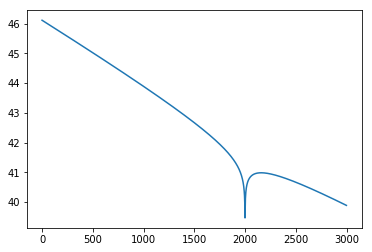

In [92]:
from timml import *
ml_1a = ModelMaq(kaq= 10, z=[0,-20])
uf_1a = Uflow(ml_1a, 2.0/1000, 0)
rf_1a = Constant(ml_1a, xr= 3000, yr = 0, hr=40)
wl1 = Well(ml_1a,xw=2000,yw=1000,layers =0,Qw = 400, rw =0.5)
ml_1a.solve()

plt.figure()
plt.plot(np.arange(3000),ml_1a.headalongline(np.arange(3000),1000)[0])
plt.show();

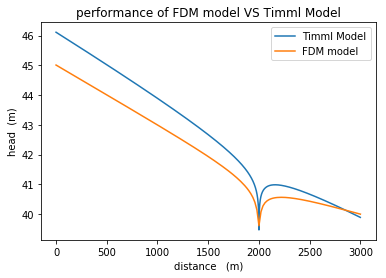

Head at well is 39.47 meters in Timml Model


F:\Anaconda\lib\site-packages\scipy\sparse\compressed.py:774: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


Head at well with discharge is 39.61 meter and without discharge is 40.00 meter in FDM model
Drawdown at the well is 0.39 meters


In [93]:
plt.figure()
plt.plot(np.arange(3000),ml_1a.headalongline(np.arange(3000),1000)[0], label='Timml Model')
plt.plot(xy(L,W)[0],h_FDM[50,:], label='FDM model')
plt.title("performance of FDM model VS Timml Model")
plt.xlabel('distance   (m)')
plt.ylabel('head  (m)')
plt.legend()
plt.show()
print("Head at well is %.2f meters in Timml Model"%(ml_1a.head(2000,1000)))
Q = np.zeros((nr,nc))
h_FDM_withoutwell = fdflow(nc, nr, L, W, k, H, Q, Fh)
print("Head at well with discharge is %.2f meter and without discharge is %.2f meter in FDM model"%(h_FDM[50,100], h_FDM_withoutwell[50,100]))
print("Drawdown at the well is %.2f meters"%(h_FDM_withoutwell[50,100] - h_FDM[50,100]))

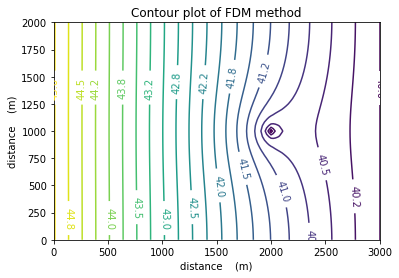

In [62]:
x, y = xy(L, W)
cs = plt.contour(x, y, h_FDM, 20)
plt.clabel(cs, fmt='%1.1f')
plt.axis('scaled')
plt.title("Contour plot of FDM method")
plt.xlabel("distance    (m)")
plt.ylabel("distance    (m)")
plt.show()

## Discharge between cells

Functions are created to compute the discharge between cells in the $x$-direction and $y$ direction. Note that the array with cell-by-cell discharges in the $x$-direction has one column less that the array with head values. Similarly, the array with the cell-by-cell discharges in the $y$-direction has one row less than the array with head values. The discharge `U[i,j]` is the discharge through the right side of cell `i,j`. The  discharge `V[i,j]` is the discharge through the front side of cell `i,j`. 

In [44]:
def Ufunc(nc, nr, L, W, k, H, h):
    kH = k * H
    C = W[:, np.newaxis] * 2 * kH[:, :-1] * kH[:, 1:] / (
        kH[:, 1:] * L[:-1] + kH[:, :-1] * L[1:] )
    U = C * (h[:, :-1] - h[:, 1:])
    return U

def Vfunc(nc, nr, L, W, k, H, h):
    kH = k * H
    D = L * 2 * kH[:-1, :] * kH[1:, :] / (
        kH[1:, :] * W[:-1, np.newaxis] + kH[:-1, :] * W[1:, np.newaxis] )
    V = D * (h[:-1, :] - h[1:, :])
    return V

U = Ufunc(nc, nr, L, W, k, H, h_FDM)
V = Vfunc(nc, nr, L, W, k, H, h_FDM)


The stream function may be computed at the corners of the cells. The $x,y$ locations of the corners of the cells are given by

In [45]:
def xypsi(L, W):
    # Center of lower-left hand cell is (0,0)
    xp = np.cumsum(L)[:-1] - 0.5 * L[0]
    yp = np.hstack((0, np.cumsum(W)))
    yp = yp[::-1] - 0.5 * W[-1]
    return xp, yp


To compute the stream function in the entire model, you need to know the stream function along one boundary. For example, for the previous exercise, both the top and bottom of the model are impermeable. Let's start at the top boundary and set the stream function equal to zero (or any other constant value) along the top boundary. The stream function at all other grid points (including the bottom boundary) may then be computed. Note that for this case with a well, the stream function is constant along the bottom boundary up to the well, after which it is again constant but the value is $Q$ less.

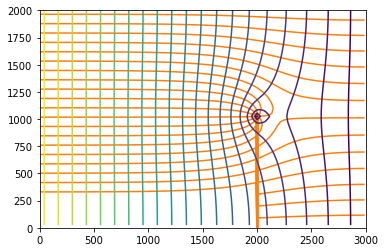

In [47]:
x, y = xy(L, W)
psi = np.zeros((nr + 1, nc - 1))
psi[1:, :] = np.cumsum(U, 0)
xp, yp = xypsi(L, W)
plt.figure()
plt.contour(xp, yp + 0.5 * W[0], psi, 20, levels=np.arange(0, 820, 40),colors='C1')
plt.contour(x, y + 0.5 * W[0], h_FDM, 20)
plt.axis('scaled')
plt.xlim(0, 3000)
plt.ylim(0, 2000)
plt.show()

## Exercise 5. Discharge of the well

Compute the cell-by-cell flow for the problem of Exercise 4. Verify that the inflow into the cell that contains the well is indeed equal to $Q$. Determine the maximum discharge of the well such that no water is drawn from the river using visual inspection of the streamlines.

In [48]:
U = Ufunc(nc, nr, L, W, k, H, h_FDM)
print("The flow into the cell which contains the well is equal to %.2f m^3/d"%(-(U[20,100]-U[20,99]+V[20,100]-V[19,100])))

The flow into the cell which contains the well is equal to 400.00 m^3/d


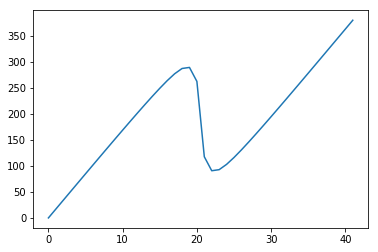

In [49]:
Q = np.zeros((nr,nc))
Q[20,100] = -660
h_FDM = fdflow(nc, nr, L, W, k, H, Q, Fh)
U = Ufunc(nc, nr, L, W, k, H, h_FDM)
x, y = xy(L, W)
psi = np.zeros((nr + 1, nc - 1))
psi = np.zeros((nr + 1, nc - 1))
psi[1:, :] = np.cumsum(U, 0)
plt.figure()
plt.plot(psi[:,101])
plt.show()

In [59]:
def max_discharge(Q_max):
    Q = np.zeros((nr,nc))
    Q[20,100] = -Q_max
    h_FDM = fdflow(nc, nr, L, W, k, H, Q, Fh)
    U = Ufunc(nc, nr, L, W, k, H, h_FDM)
    x, y = xy(L, W)
    psi = np.zeros((nr + 1, nc - 1))
    psi = np.zeros((nr + 1, nc - 1))
    psi[1:, :] = np.cumsum(U, 0)
    xp, yp = xypsi(L, W)
    plt.figure()
    print(psi[20,99:])
    plt.contour(xp, (yp + 0.5 * W[0]), psi, 20,colors='C1')
    plt.contour(x, y + 0.5 * W[0], h_FDM, 20)
    plt.axis('scaled')
    plt.xlim(0, 3000)
    plt.ylim(0, 2000)
    plt.show()


In [60]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [61]:
interact(max_discharge,Q_max=(400,1500,0.1))

A Jupyter Widget

<function __main__.max_discharge>

In [ ]:
Q = np.zeros((nr,nc))
Q[50,200] = -400

while (h_FDM[50,200:-1]<=h_FDM[50,201:]).all()==False:
    step = 20
    Q[50,200] -= step
    h_FDM = fdflow(nc, nr, L, W, k, H, Q, Fh)
    U = Ufunc(nc, nr, L, W, k, H, h_FDM)
    Q_max = Q[50,200]
    h_min=h_FDM

In [ ]:
Q[20,100] = -660
Q_max = Q[20,100]
h_FDM = fdflow(nc, nr, L, W, k, H, Q, Fh)
h_min=h_FDM

In [ ]:
U = Ufunc(nc, nr, L, W, k, H, h_min)
V = Vfunc(nc, nr, L, W, k, H, h_min)

In [ ]:
x, y = xy(L, W)
psi = np.zeros((nr + 1, nc - 1))
psi[1:, :] = np.cumsum(U, 0)
xp, yp = xypsi(L, W)
plt.figure()
plt.contour(xp, yp + 0.5 * W[0], psi, 20, levels=np.arange(0, 3000, 10),colors='r')
plt.contour(x, y + 0.5 * W[0], h_min, 20)
plt.axis('scaled')
plt.xlim(0, 3000)
plt.ylim(0, 2000)
plt.show()
print("The maximum discharge of the pumping well is around %s m^3/d"%(-Q_max))

In [ ]:
x, y = xy(L, W)
cs = plt.contour(x, y, h_min, 50)
plt.clabel(cs, fmt='%1.2f')
plt.axis('scaled')
plt.title("Contour plot of FDM method")
plt.xlabel("distance    (m)")
plt.ylabel("distance    (m)")
plt.show()